In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

ENERGY = 25 # GeV

PARTICLE = "gamma"

root_dir = f"Sim_maps/Slices_{ENERGY}GeV_{PARTICLE}s"

NUM_EVENTS = len(os.listdir(root_dir))

NUM_BINS = 400

energy_deps = np.empty( (NUM_EVENTS, NUM_BINS), dtype=float )

z_array = np.arange(NUM_BINS) + 0.5 # in mm

for evn, filename in enumerate(os.listdir(root_dir)):

    path = os.path.join(root_dir,filename)

    with open(path) as file:

        file.readline() # skip first lines in the header
        file.readline()
        file.readline()

        for bin_n, line in enumerate(file):

            eDep_slice = float(line.split(",")[3])

            energy_deps[evn, bin_n] = eDep_slice


## 4X0 vs 25X0 correlations

Text(0.05, 0.95, 'Correlation coef. = 0.187')

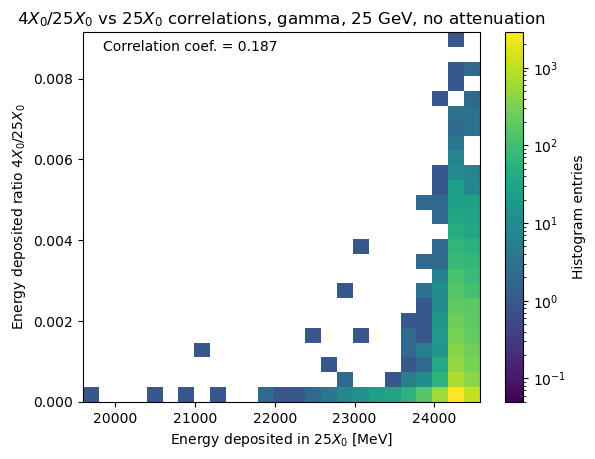

In [79]:

eDep_4X  = np.sum(energy_deps[:,:16], axis = 1)
eDep_25X = np.sum(energy_deps,        axis = 1)

eDep_ratio = eDep_4X/eDep_25X

plt.figure()

corrcoef = np.corrcoef(eDep_25X, eDep_ratio)[1,0]

plt.hist2d(eDep_25X, eDep_ratio, bins=[25, 25], norm=colors.LogNorm(vmin=0.05))
plt.xlabel("Energy deposited in $25X_0$ [MeV]")
plt.ylabel("Energy deposited ratio $4X_0/25X_0$")
plt.title(f"$4X_0/25X_0$ vs $25X_0$ correlations, {PARTICLE}, {ENERGY} GeV, no attenuation")

cbar = plt.colorbar()
cbar.ax.set_ylabel("Histogram entries")

plt.text(0.05, 0.95, "Correlation coef. = {:.3f}".format(corrcoef), transform=plt.gca().transAxes)


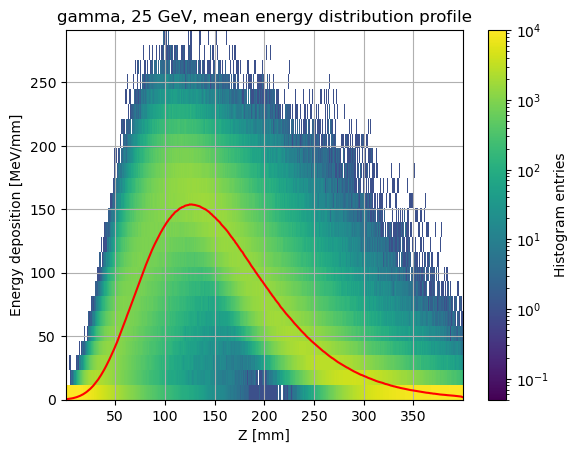

In [64]:
plt.figure()
plt.hist2d(np.tile(z_array, NUM_EVENTS), energy_deps.flatten(), bins=[NUM_BINS, 25], norm=colors.LogNorm(vmin=0.05))
plt.xlabel("Z [mm]")
plt.ylabel("Energy deposition [MeV/mm]")
plt.title(f"{PARTICLE}, {ENERGY} GeV, event vise distrubutin of energy along Z axis")

cbar = plt.colorbar()
cbar.ax.set_ylabel("Histogram entries")


# plt.figure()
plt.plot(np.mean(energy_deps, axis=0), "red")

plt.xlabel("Z [mm]")
plt.ylabel("Energy deposition [MeV/mm]")
plt.title(f"{PARTICLE}, {ENERGY} GeV, mean energy distribution profile")

# plt.text(0.5, 0.8, f"{ENERGY} GeV gammas\naveraged over {NUM_EVENTS} events", transform=plt.gca().transAxes)
plt.grid()

In [65]:
from scipy.optimize import curve_fit 

def dispHistAndGauss(ax, data):

    n_bins = int(np.sqrt(data.size))
    bin_size = (np.max(data) - np.min(data))/n_bins

    histCounts, edges, _ = ax.hist(data, bins = n_bins)
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(data)
    sig = np.std(data, ddof=1)
    A = data.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(data), np.max(data), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$\n$\mu={:.2e}$\n$\sigma/\mu={:.2e}$".format(sig, mu, sig/mu))

    liml, limr = ax.get_xlim()
    ax.set_xlim(max(liml, mu-5*sig), min(limr, mu+5*sig))

    ax.legend()

## Average Z for each event ( Z weighted by E(Z) )

Text(0.5, 1.0, 'gamma, 25 GeV, event wise distribution of average Z')

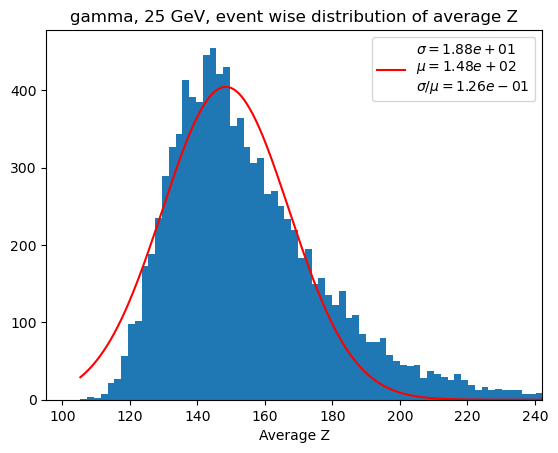

In [66]:
average_Z = np.sum(energy_deps * z_array, axis = 1 ) / np.sum(energy_deps, axis = 1 )

plt.figure()
ax = plt.gca()

dispHistAndGauss(ax, average_Z)

plt.xlabel("Average Z")
plt.title(f"{PARTICLE}, {ENERGY} GeV, event wise distribution of average Z")

## Weight Z by the light absorbtion

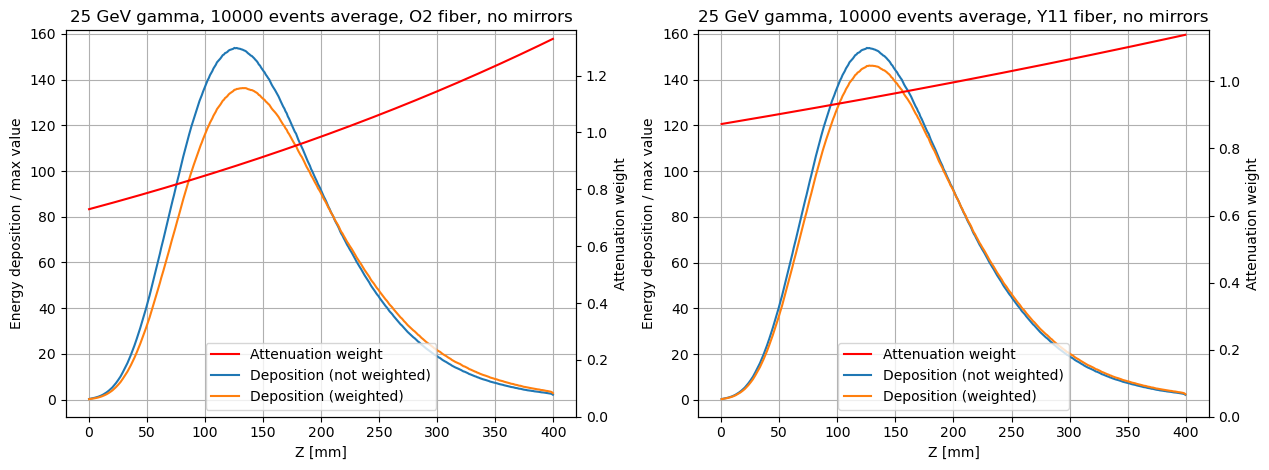

In [ ]:
def draw_Ez_dep_weighted(axl, absr_len):

    aten_W = np.exp(-((500-z_array)/absr_len))
    aten_W /= np.mean(aten_W)

    eDep_aver = np.mean(energy_deps, axis=0)
    # eDep_aver /= np.max(eDep_aver)

    eDep_aver_w = np.mean(energy_deps, axis=0)*aten_W
    # eDep_aver_w /= np.max(eDep_aver_w)

    ln1 = axl.plot(z_array, eDep_aver, label="Deposition (not weighted)")
    ln2 = axl.plot(z_array, eDep_aver_w, label="Deposition (weighted)")

    axl.set_xlabel("Z [mm]")
    axl.set_ylabel("Energy deposition [MeV/mm]")

    axl.grid()
    # axl.set_ylim(0, 1)

    axr = axl.twinx()

    ln3 = axr.plot(z_array, aten_W, "r", label="Attenuation weight")
    axr.set_ylim(0, None)
    axr.set_ylabel("Attenuation weight")


    # show_legends
    lns = ln3+ln1+ln2
    labs = [l.get_label() for l in lns]
    axl.legend(lns, labs, loc="lower center")




fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2*6.4,4.8))

draw_Ez_dep_weighted(ax1, 665.9)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, O2 fiber, no mirrors")

draw_Ez_dep_weighted(ax2, 1500)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, Y11 fiber, no mirrors")

fig.tight_layout()



## Efective detected energy distribution

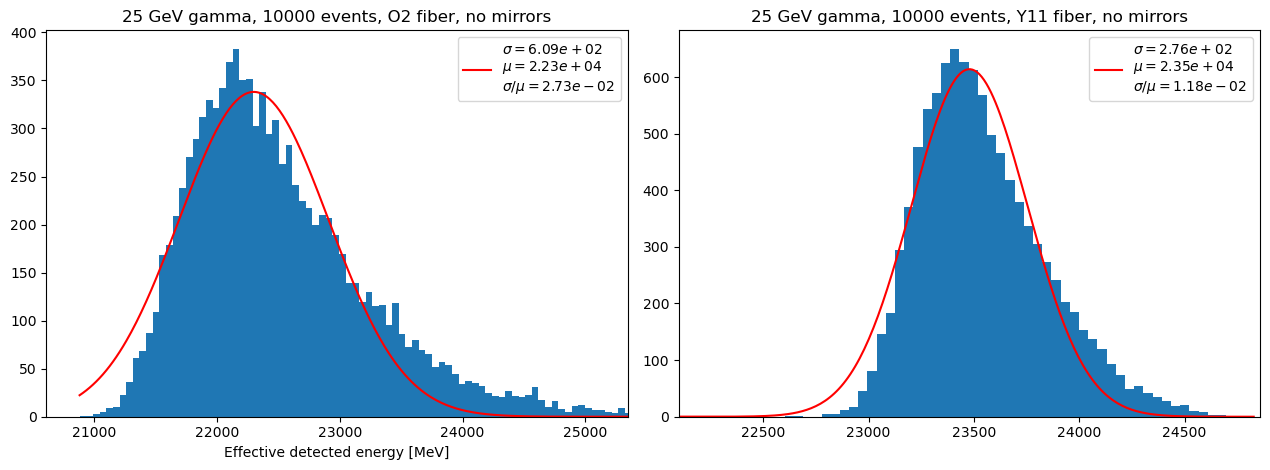

In [73]:
def draw_Ez_dep_weighted(ax, absr_len):

    aten_W = np.exp(-((500-z_array)/absr_len))
    aten_W /= np.mean(aten_W)

    eDep_aver = np.mean(energy_deps, axis=0)
    eDep_aver /= np.max(eDep_aver)

    eDep_eff = np.sum(energy_deps*aten_W, axis=1)


    dispHistAndGauss(ax, eDep_eff)




fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2*6.4,4.8))

draw_Ez_dep_weighted(ax1, 665.9)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, O2 fiber, no mirrors")
ax1.set_xlabel("Effective detected energy [MeV]")

draw_Ez_dep_weighted(ax2, 1500)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, Y11 fiber, no mirrors")
ax1.set_xlabel("Effective detected energy [MeV]")

fig.tight_layout()

# Attenuation with reflection
## Weight Z by the light absorbtion

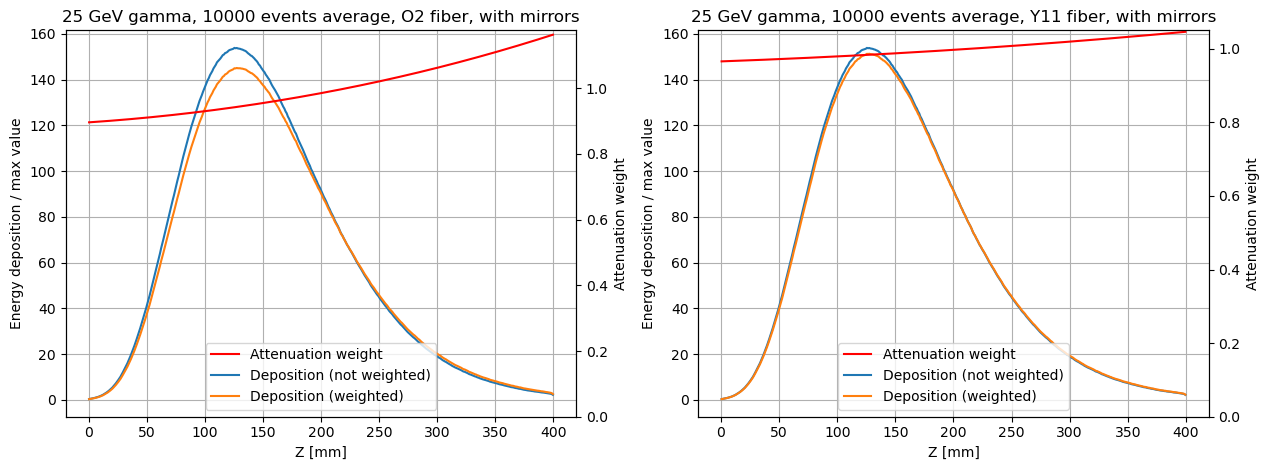

In [76]:
def draw_Ez_dep_weighted(axl, absr_len):

    aten_W = np.exp(-((500-z_array)/absr_len)) + 0.7 * np.exp(-((500 +z_array)/absr_len))
    aten_W /= np.mean(aten_W)

    eDep_aver = np.mean(energy_deps, axis=0)

    eDep_aver_w = np.mean(energy_deps, axis=0)*aten_W

    ln1 = axl.plot(z_array, eDep_aver, label="Deposition (not weighted)")
    ln2 = axl.plot(z_array, eDep_aver_w, label="Deposition (weighted)")

    axl.set_xlabel("Z [mm]")
    axl.set_ylabel("Energy deposition / max value")

    axl.grid()
    # axl.set_ylim(0, 1)

    axr = axl.twinx()

    ln3 = axr.plot(z_array, aten_W, "r", label="Attenuation weight")
    axr.set_ylim(0, None)
    axr.set_ylabel("Attenuation weight")


    # show_legends
    lns = ln3+ln1+ln2
    labs = [l.get_label() for l in lns]
    axl.legend(lns, labs, loc="lower center")




fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2*6.4,4.8))

draw_Ez_dep_weighted(ax1, 665.9)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, O2 fiber, with mirrors")

draw_Ez_dep_weighted(ax2, 1500)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events average, Y11 fiber, with mirrors")

fig.tight_layout()



## Efective detected energy distribution

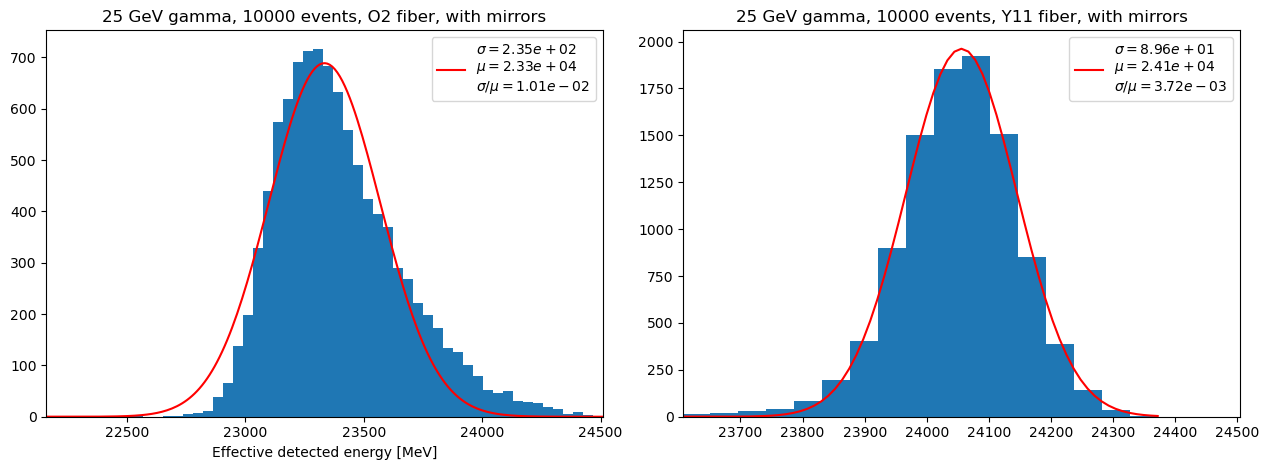

In [78]:
def draw_Ez_dep_weighted(ax, absr_len):

    aten_W = np.exp(-((500-z_array)/absr_len)) + 0.7 * np.exp(-((500 +z_array)/absr_len))
    aten_W /= np.mean(aten_W)

    # eDep_aver = np.mean(energy_deps, axis=0)
    # eDep_aver /= np.max(eDep_aver)

    eDep_eff = np.sum(energy_deps*aten_W, axis=1)


    dispHistAndGauss(ax, eDep_eff)




fig, (ax1, ax2) = plt.subplots(1,2, figsize=(2*6.4,4.8))

draw_Ez_dep_weighted(ax1, 665.9)
ax1.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, O2 fiber, with mirrors")
ax1.set_xlabel("Effective detected energy [MeV]")

draw_Ez_dep_weighted(ax2, 1500)
ax2.set_title(f"{ENERGY} GeV {PARTICLE}, {NUM_EVENTS} events, Y11 fiber, with mirrors")
ax1.set_xlabel("Effective detected energy [MeV]")

fig.tight_layout()